In [ ]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import keras
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.layers.merge import Concatenate, concatenate
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, Input, add
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
import nltk
from tqdm import tqdm, tqdm_notebook
from google.colab import output
tqdm.pandas()

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'hsankesara/flickr-image-dataset'
!unzip -u flickr-image-dataset.zip
!rm -rf flickr-image-dataset.zip
output.clear()

In [ ]:
image_captions = {}
data = pd.read_csv('flickr30k_images/results.csv',sep=r'[|]')
data.columns = ['image_name', 'comment_number', 'comment']
for index, row in data.iterrows():
  if row[0] not in image_captions:
    image_captions[row[0]] = []
  image_captions[row[0]].append(row[2])
image_captions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


{'1000092795.jpg': [' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
  ' Two young , White males are outside near many bushes .',
  ' Two men in green shirts are standing in a yard .',
  ' A man in a blue shirt standing in a garden .',
  ' Two friends enjoy time spent together .'],
 '10002456.jpg': [' Several men in hard hats are operating a giant pulley system .',
  ' Workers look down from up above on a piece of equipment .',
  ' Two men working on a machine wearing hard hats .',
  ' Four men on top of a tall structure .',
  ' Three men on a large rig .'],
 '1000268201.jpg': [' A child in a pink dress is climbing up a set of stairs in an entry way .',
  ' A little girl in a pink dress going into a wooden cabin .',
  ' A little girl climbing the stairs to her playhouse .',
  ' A little girl climbing into a wooden playhouse',
  ' A girl going into a wooden building .'],
 '1000344755.jpg': [' Someone in a blue shirt and hat is standing on stair and

In [ ]:
images_base_url = '/content/flickr30k_images/flickr30k_images/'

In [ ]:
image_list = glob.glob(f'{images_base_url}*.jpg')

In [ ]:
len(image_list)

31783

In [ ]:
train_len = 6000
val_len = 2000
test_len = 2000

In [ ]:
X_train = image_list[: train_len]
X_test = image_list[train_len : train_len + test_len]
X_val = image_list[train_len + test_len : train_len + test_len + val_len]

In [ ]:
print(len(X_train),len(X_test),len(X_val))

6000 2000 2000


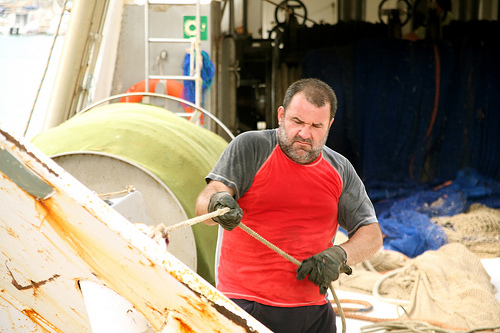

In [ ]:
Image.open(X_train[100])

In [ ]:
def preprocess_image(path):
  img = image.load_img(path, target_size=(299, 299))
  img = image.img_to_array(img)
  preprocessed_image = preprocess_input(img)
  preprocessed_image = np.reshape(preprocessed_image,(1,299,299,3))
  return preprocessed_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


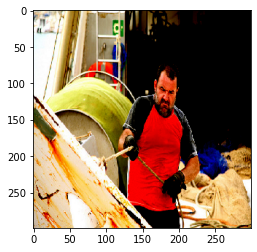

In [ ]:
plt.imshow(np.squeeze(preprocess_image(X_train[100])))

In [ ]:
inception = InceptionV3('imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

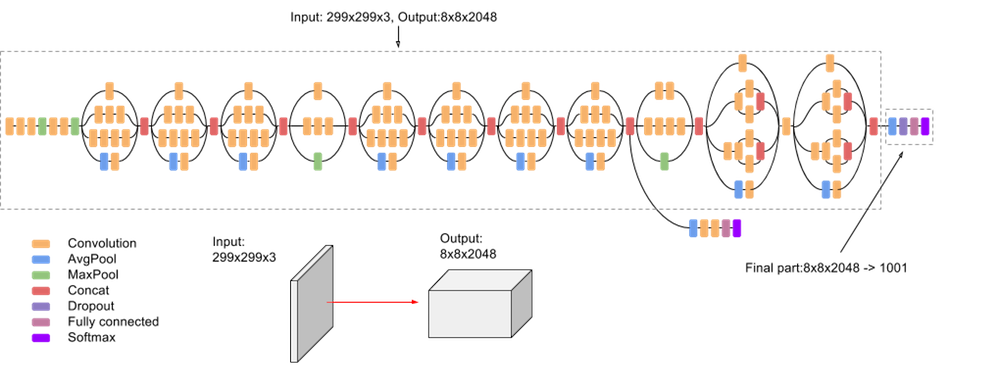

In [ ]:
!wget https://cloud.google.com/tpu/docs/images/inceptionv3onc--oview.png
output.clear()
Image.open('inceptionv3onc--oview.png')

In [ ]:
encoder_input = inception.input
encoder_output = inception.layers[-2].output
encoder = Model(encoder_input,encoder_output)

In [ ]:
def encode(path):
  img = preprocess_image(path)
  encoded_img = encoder.predict(img)
  return encoded_img

In [ ]:
encode(X_train[0]).shape

(1, 2048)

In [ ]:
encoding_train = {}
for img in tqdm(X_train):
    encoding_train[img[len(images_base_url):]] = encode(img)

100%|██████████| 6000/6000 [05:07<00:00, 19.54it/s]


In [ ]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

If the encodings are available, cells before this one are not necessary.


In [ ]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [ ]:
encoding_train

{'4835922124.jpg': array([[1.3336078 , 0.28231317, 0.14492813, ..., 0.17683674, 0.10235408,
         1.1630147 ]], dtype=float32),
 '342872408.jpg': array([[0.16969167, 0.09602772, 0.3686483 , ..., 0.922674  , 0.38374168,
         0.5910578 ]], dtype=float32),
 '3356901257.jpg': array([[0.41661498, 0.16663894, 0.39993882, ..., 0.15141216, 0.36296377,
         0.265663  ]], dtype=float32),
 '2429405579.jpg': array([[0.8375219 , 0.5771513 , 0.9977948 , ..., 1.6110694 , 0.7113559 ,
         0.56509304]], dtype=float32),
 '4946045875.jpg': array([[0.17954113, 0.44946995, 0.3292506 , ..., 0.67090905, 0.14008045,
         0.14951591]], dtype=float32),
 '6661528969.jpg': array([[0.02313053, 0.11012039, 0.02340056, ..., 0.06706057, 0.30500954,
         1.1755905 ]], dtype=float32),
 '1569687608.jpg': array([[0.30688494, 0.80773544, 0.2587803 , ..., 0.9156027 , 0.35595334,
         0.3135146 ]], dtype=float32),
 '2355093195.jpg': array([[0.02396961, 0.03848732, 0.06081802, ..., 0.04830716, 0.18

In [ ]:
encoding_test = {}
for img in tqdm(X_test):
    encoding_test[img[len(images_base_url):]] = encode(img)

100%|██████████| 2000/2000 [01:42<00:00, 19.47it/s]


In [ ]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [ ]:
train_captions = {}
for i in X_train:
  name = i[len(images_base_url):]
  if name in image_captions:
    train_captions[i] = image_captions[name]

In [ ]:
val_captions = {}
for i in X_val:
  name = i[len(images_base_url):]
  if name in image_captions:
    val_captions[i] = image_captions[name]

In [ ]:
test_captions = {}
for i in X_test:
  name = i[len(images_base_url):]
  if name in image_captions:
    test_captions[i] = image_captions[name]

In [ ]:
len(val_captions)

2000

In [ ]:
len(train_captions)

6000

In [ ]:
len(test_captions)

2000

In [ ]:
caps = []
for key, val in train_captions.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [ ]:
words = [i.split() for i in caps]

In [ ]:
unique = []
for i in words:
    unique.extend(i)

In [ ]:
unique = list(set(unique))

In [ ]:
with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d)

In [ ]:
unique = pickle.load(open('unique.p', 'rb'))

In [ ]:
vocab_size = len(unique)
vocab_size

11080

In [ ]:
word2idx = {val:index for index, val in enumerate(unique)}
idx2word = {index:val for index, val in enumerate(unique)}

In [ ]:
print(word2idx['<start>'])
print(idx2word[2552])

7830
mountaintops


In [ ]:
max_len = 0
max_len = max([len(c.split()) for c in caps])
max_len

81

In [ ]:
!rm -rf /content/training_dataset.txt
f = open('training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [ ]:
for key, val in train_captions.items():
    for i in val:
        f.write(key[len(images_base_url):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [ ]:
df = pd.read_csv('training_dataset.txt', delimiter='\t')

In [ ]:
len(df)

30000

In [ ]:
df

,image_id,captions
0,4835922124.jpg,<start> A woman with a purple purse sits on t...
1,4835922124.jpg,<start> Two women on the subway complete enth...
2,4835922124.jpg,<start> Women playing on their cellphones on ...
3,4835922124.jpg,<start> a train with two women using their ce...
4,4835922124.jpg,<start> People are sitting on a transit train...
...,...,...
29995,6953548178.jpg,<start> A crowd of people surrounded by large...
29996,6953548178.jpg,<start> There is an audience watching a guy i...
29997,6953548178.jpg,<start> A crowd of people watching as a large...
29998,6953548178.jpg,<start> a city of people gathered around the ...


<start>  A group of people are watching a statue being erected . <end>


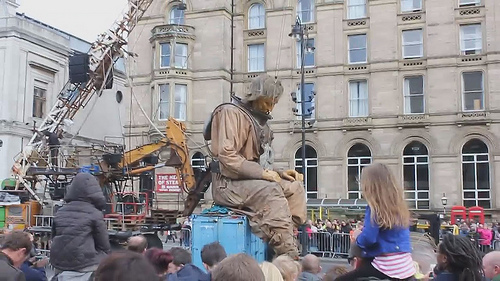

In [ ]:
c = [i for i in df['captions']]
imgs = [i for i in df['image_id']]
print(c[-1])
Image.open(f"{images_base_url}{imgs[-1]}")

# Model

In [ ]:
embedding_size = 300

In [ ]:
inp_1 = Input(shape=(2048,))
model1 = Dense(embedding_size,activation='relu')(inp_1)
model1_out = RepeatVector(max_len)(model1)

In [ ]:
inp_2 = Input(shape=(max_len,))
model2 = Embedding(vocab_size+1, embedding_size,input_length=max_len)(inp_2)
model2 = LSTM(256, input_shape=(66,300), return_sequences=True)(model2)
model2_out = TimeDistributed(Dense(300))(model2)

In [ ]:
concat = concatenate([model1_out, model2_out])

In [ ]:
model = Bidirectional(LSTM(256, return_sequences=False))(concat)
model = Dense(vocab_size)(model)
out = Activation('softmax')(model)

In [ ]:
final = Model([inp_1, inp_2], out)

In [ ]:
final.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
final.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 81)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 81, 300)      3324300     input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          614700      input_2[0][0]                    
_______________________________________________________________________________________

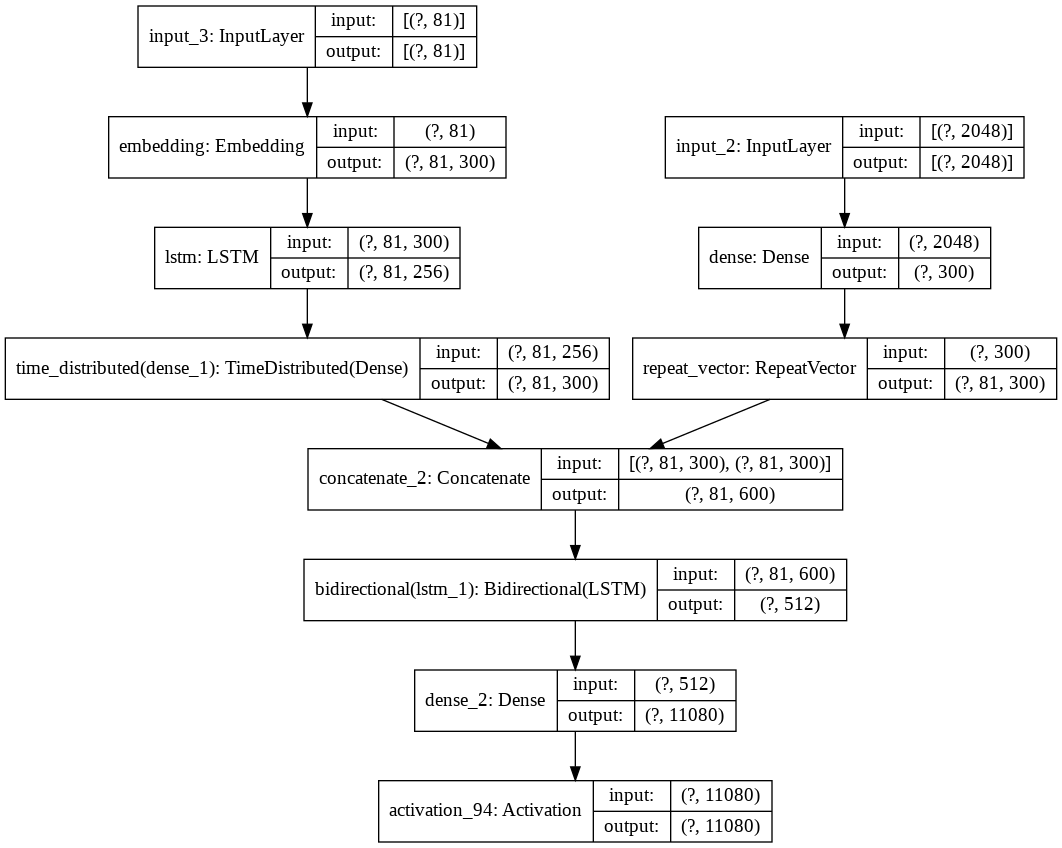

In [ ]:
keras.utils.plot_model(final, show_shapes=True)

In [ ]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    # images.append(current_image)
                    images.append(np.squeeze(current_image))

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        # print(images.shape, partial_caps.shape, next_words.shape)
                        # print(type(images), type(partial_caps), type(next_words))
                        yield ([images, partial_caps], next_words)
                        # yield ([array(Ximages), array(XSeq)], array(y))
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [ ]:
samples_per_epoch = -1
for ca in caps:
    samples_per_epoch += len(ca.split())-1
samples_per_epoch

433478

In [ ]:
checkpoint_path = "/content/drive/My Drive/NLP Reading Group/Image_Captioning/checkpoints"

In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    save_freq=5)

In [ ]:
final.fit(data_generator(batch_size=128),  epochs=2,callbacks=[checkpoint_callback])

Epoch 1/2
  18659/Unknown - 9119s 489ms/step - loss: 4.0212 - accuracy: 0.3520

In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
print(test_captions[X_test[0]])
plt.imshow(f"{image_base_url}{X_test[0]}")